#### Import packages and device selection

In [38]:
import os
import re
import cv2
from tqdm.notebook import tqdm
import optuna
from optuna.trial import TrialState
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.functional.image import image_gradients, structural_similarity_index_measure
from torchvision import transforms
from torchinfo import summary
from sklearn.model_selection import KFold, train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [39]:
SIZE = 160
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [40]:
print("Using device: ", device)

Using device:  cuda


## Dataset Loading and Preprocessing

In [91]:
def sort_files(folder):
    convert_func = lambda x: int(x) if x.isdigit() else x.lower()
    key_func = lambda x: [convert_func(c) for c in re.split('([0-9]+)', x)]
    return sorted(folder, key=key_func)

data_color = []
path = '../data/color'
folder = os.listdir(path)
folder = sort_files(folder)
for file in tqdm(folder):
    img = cv2.imread(path + '/' + file, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img = cv2.resize(img, (SIZE, SIZE))
    data_color.append(img)
data_color = np.array(data_color)

data_gray = []
path = '../data/gray'
folder = os.listdir(path)
folder = sort_files(folder)
for file in tqdm(folder):
    img = cv2.imread(path + '/' + file, 1)
    img = cv2.resize(img, (SIZE, SIZE))
    data_gray.append(img)
data_gray = np.array(data_gray)

  0%|          | 0/7129 [00:00<?, ?it/s]

  0%|          | 0/7129 [00:00<?, ?it/s]

In [92]:
print(data_color.shape, data_gray.shape)

(7129, 160, 160, 3) (7129, 160, 160, 3)


#### Display some samples

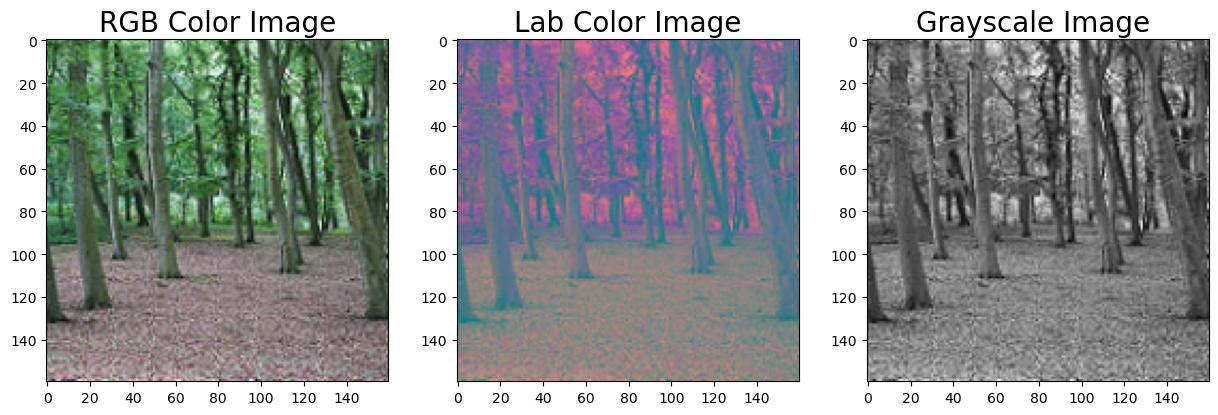

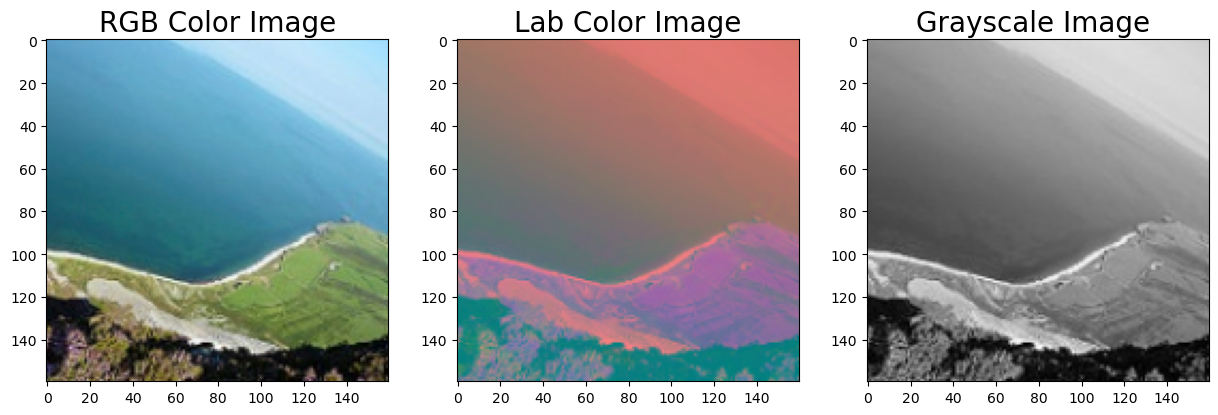

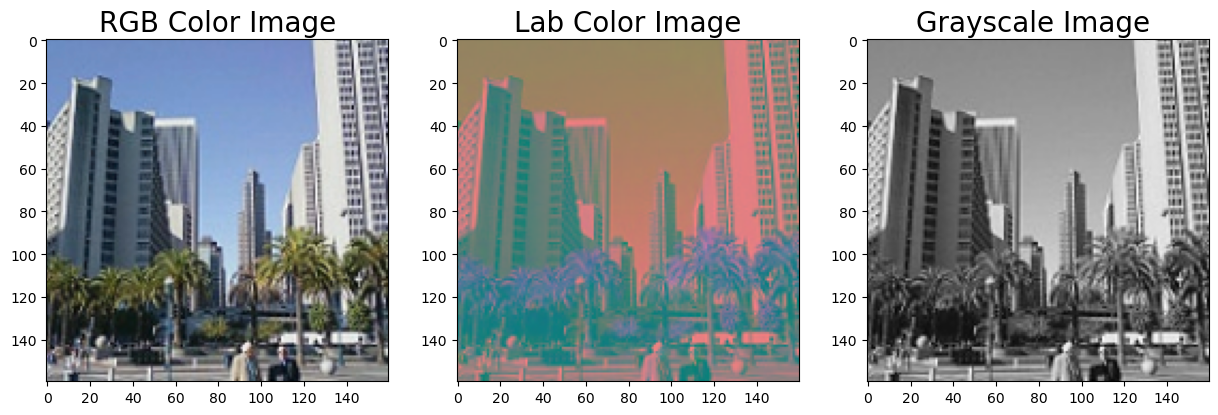

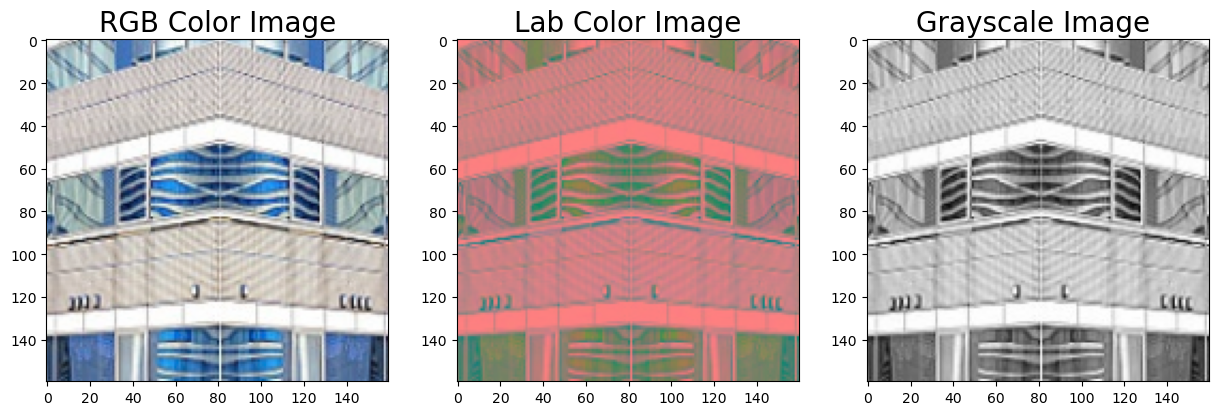

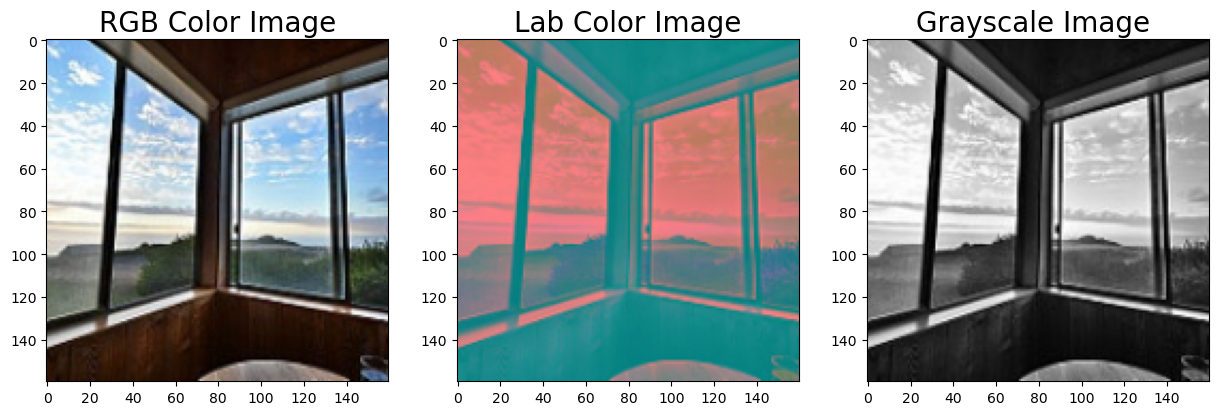

In [151]:
for _ in range(5):
    idx = np.random.randint(0, len(data_color) - 1)
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('RGB Color Image', fontsize=20)
    plt.imshow(cv2.cvtColor(data_color[idx], cv2.COLOR_LAB2RGB))
    plt.subplot(1, 3, 2)
    plt.title('Lab Color Image', fontsize=20)
    plt.imshow(data_color[idx])
    plt.subplot(1, 3, 3)
    plt.title('Grayscale Image ', fontsize=20)
    plt.imshow(data_gray[idx])
    plt.show()

#### Split into training and test data

In [192]:
gray_train, gray_test, color_train, color_test = (
    train_test_split(data_gray, data_color, test_size=0.2, random_state=42))
gray_train = torch.stack([transforms.ToTensor()(x) for x in gray_train], dim=0)
color_train = torch.stack([transforms.ToTensor()(x) for x in color_train], dim=0)
gray_test = torch.stack([transforms.ToTensor()(x) for x in gray_test], dim=0)
color_test = torch.stack([transforms.ToTensor()(x) for x in color_test], dim=0)

In [193]:
gray_mean = gray_train.mean(dim=(0, 2, 3))
gray_std = gray_train.std(dim=(0, 2, 3))
color_mean = color_train.mean(dim=(0, 2, 3))
color_std = color_train.std(dim=(0, 2, 3))

In [194]:
print(color_mean, color_std)
print(gray_mean, gray_std)

tensor([0.4738, 0.4963, 0.5037]) tensor([0.2587, 0.0346, 0.0710])
tensor([0.4461, 0.4461, 0.4461]) tensor([0.2529, 0.2529, 0.2529])


In [152]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_gray, data_color, gray_transform=None, color_transform=None):
        self.data_color = color_transform(data_color)
        self.data_gray = gray_transform(data_gray)

    def __len__(self):
        return len(self.data_gray)

    def __getitem__(self, idx):
        return self.data_gray[idx], self.data_color[idx]

## Training pipeline

In [197]:
trainset = MyDataset(gray_train, color_train, gray_transform=transforms.Normalize(mean=gray_mean, std=gray_std),
                     color_transform=transforms.Normalize(mean=color_mean, std=color_std))
testset = MyDataset(gray_test, color_test, gray_transform=transforms.Normalize(mean=gray_mean, std=gray_std),
                    color_transform=transforms.Normalize(mean=color_mean, std=color_std))
del gray_train, gray_test, color_train, color_test # release memory

#### Early stopping used to stop training if model begins to overfit

In [ ]:
def save_checkpoint(model, name='checkpoint'):
    torch.save(model.state_dict(), f"../models/{name}.pth")

class EarlyStopping:
    def __init__(self, patience=10, delta=5e-6):
        self.patience = patience
        self.counter = 0
        self.best_score = np.Inf
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, net):
        if self.best_score > val_loss:
            self.best_score = val_loss
            self.counter = 0
            save_checkpoint(net)
        elif self.best_score + self.delta < val_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

#### ImageGradienLoss class and fit/predict methods

$ \_comp.pow(2).sum(dim=1)$ computes $∑𝑐[Δ]^2$ directly, which is algebraically identical to $∥Δ∥_2^2$ but skips the square‐root.

In [ ]:
class ImageGradientLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(ImageGradientLoss, self).__init__()

    def forward(self, inputs, targets):
        dh_in, dv_in = image_gradients(inputs) # (B, C, H, W-1), (B, C, H-1, W)
        dh_tar, dv_tar = image_gradients(targets)
        dh_comp = (dh_in - dh_tar) ** 2
        dv_comp = (dv_in - dv_tar) ** 2
        return (dh_comp + dv_comp).sum()

def compute_pcc(pred, targets):
    pred_flat = pred.reshape(pred.size(0), -1)
    target_flat = targets.reshape(targets.size(0), -1)
    vx = pred_flat - pred_flat.mean(dim=1, keepdim=True)
    vy = target_flat - target_flat.mean(dim=1, keepdim=True)
    numerator = (vx * vy).sum(dim=1) # covariance
    denominator = torch.sqrt((vx**2).sum(dim=1) * (vy**2).sum(dim=1)) # standard deviation
    return (numerator / denominator).mean()

def fit(net, trainloader, optimizer, loss_fn1=nn.MSELoss(reduction='sum'), loss_fn2=ImageGradientLoss(), coeff=0.5):
    net.train()
    total_loss, total_rmse, total_psnr, total_ssim, total_pcc, count = 0, 0, 0, 0, 0, 0
    for grays, colors in trainloader:
        grays, colors = grays.to(device), colors.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = net(grays)
            numel = out.numel()
            loss1, loss2 = loss_fn1(out, colors), loss_fn2(out, colors)
            loss = (coeff * loss1 + (1-coeff) * loss2) / numel
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        count += len(colors)
        with torch.no_grad():
            batch_rmse = torch.sqrt(loss1 / numel)
            batch_psnr = (20 * torch.log10(1.0 / batch_rmse))
            total_rmse += batch_rmse.item() * len(colors)
            total_psnr += batch_psnr.item() * len(colors)
            total_ssim += structural_similarity_index_measure(out, colors).item() * len(colors)
            total_pcc += compute_pcc(out, colors).item() * len(colors)
        del out, grays, colors, loss1, loss2, loss
    return total_loss / count, total_rmse / count, total_psnr / count, total_ssim / count, total_pcc / count

def predict(net, testloader, loss_fn1=nn.MSELoss(reduction='sum'), loss_fn2=ImageGradientLoss(), coeff=0.5):
    net.eval()
    total_loss, total_rmse, total_psnr, total_ssim, total_pcc, count = 0, 0, 0, 0, 0, 0
    ins, preds, truths = [], [], []
    with torch.no_grad():
        for grays, colors in testloader:
            grays, colors = grays.to(device), colors.to(device)
            with torch.cuda.amp.autocast():
                out = net(grays)
                ins.append(grays.cpu())
                preds.append(out.cpu())
                truths.append(colors.cpu())
                numel = out.numel()
                loss1, loss2 = loss_fn1(out, colors), loss_fn2(out, colors)
                loss = (coeff * loss1 + (1 - coeff) * loss2) / numel
            total_loss += loss.item()
            count += len(colors)
            batch_rmse = torch.sqrt(loss1 / numel)
            batch_psnr = (20 * torch.log10(1.0 / batch_rmse))
            total_rmse += batch_rmse.item() * len(colors)
            total_psnr += batch_psnr.item() * len(colors)
            total_ssim += structural_similarity_index_measure(out, colors).item() * len(colors)
            total_pcc += compute_pcc(out, colors).item() * len(colors)
            del out, grays, colors, loss1, loss2, loss
    return ins, preds, truths, total_loss / count, total_rmse / count, total_psnr / count, total_ssim / count, total_pcc / count

#### Objective method for k fold cross validation

In [ ]:
def objective(trial, trainset, X):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [64,256, 512, 1024])
    coeff = trial.suggest_float('coeff', 0.0, 1.0, log=False)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    val_losses, mean_loss = [], 0
    train_loss, train_rmse, train_psnr, train_ssim, train_pcc = 0, 0, 0, 0, 0
    val_loss, val_rmse, val_psnr, val_ssim, val_pcc = 0, 0, 0, 0, 0
    split_n = 0
    prog_bar = tqdm(kf.split(X), desc="Splits", position=0)
    for train_idx, val_idx in prog_bar:
        split_n += 1
        trainloader = DataLoader(trainset, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx), num_workers=4, pin_memory=True, prefetch_factor=2)
        valloader = DataLoader(trainset, batch_size=batch_size, sampler=SubsetRandomSampler(val_idx), num_workers=4, pin_memory=True, prefetch_factor=2)
        del train_idx, val_idx
        net = Net().to(device)
        optimizer = optim.Adam(net.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.05, patience=2)
        early_stopping = EarlyStopping()
        for epoch in range(50):
            train_loss, train_rmse, train_psnr, train_ssim, train_pcc = fit(net, trainloader, optimizer, coeff=coeff)
            ins, preds, truths, val_loss, val_rmse, val_psnr, val_ssim, val_pcc = predict(net, valloader, coeff=coeff)
            del ins, preds, truths
            scheduler.step(val_ssim)
            early_stopping(val_loss, net)
            prog_bar.set_description(
                f"Split {split_n} - Epoch {epoch + 1} |\nlr={lr:.3e}, batch size={batch_size:.3e}, coeff={coeff:.3e} |\n"
                f"Metrics train/val: RMSE={train_rmse:.3e}/{val_rmse:.3e}, "
                f"PSNR={train_psnr:.3e}/{val_psnr:.3e}, SSIM={train_ssim:.3e}/{val_ssim:.3e}, "
                f"PCC={train_pcc:.3e}/{val_pcc:.3e} | Loss: {train_loss:.3e}/{val_loss:.3e}")
            torch.cuda.empty_cache()
            if early_stopping.early_stop:
                break
        del net, optimizer, sheduler, early_stopping,
        val_losses.append(val_loss)
        mean_loss = np.mean(val_losses)
        trial.report(mean_loss, split_n)
        torch.cuda.empty_cache()
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return mean_loss

#### CAE NN definition

out = (in - kernel + 2 * pad) / stride + 1

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 4, 2, 1)
        self.conv2 = nn.Conv2d(128, 128, 4, 2, 1)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1)
        self.conv5 = nn.Conv2d(512, 512, 4, 2, 1)
        self.convt1 = nn.ConvTranspose2d(512, 512, 4, 2, 1)
        self.convt2 = nn.ConvTranspose2d(1024, 256, 4, 2, 1)
        self.convt3 = nn.ConvTranspose2d(512, 128, 4, 2, 1)
        self.convt4 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.convt5 = nn.ConvTranspose2d(256, 3, 4, 2, 1)
        self.bnorm1 = nn.BatchNorm2d(256)
        self.bnorm2 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout(0.2)
        self.lrelu = nn.LeakyReLU()
        self.final = nn.Conv2d(6, 3, 1, 1)

    def forward(self, x):
        d1 = self.lrelu(self.conv1(x)) # (B, 128, 80, 80)
        d2 = self.lrelu(self.conv2(d1)) # (B, 128, 40, 40)
        d3 = self.lrelu(self.bnorm1(self.conv3(d2))) # (B, 256, 20, 20)
        d4 = self.lrelu(self.bnorm2(self.conv4(d3))) # (B, 512, 10, 10)
        d5 = self.lrelu(self.bnorm2(self.conv5(d4))) # (B, 512, 5, 5)
        u1 = self.lrelu(self.convt1(d5)) # (B, 512, 10, 10)
        u1 = torch.cat([u1, d4], dim=1) # (B, 1024, 10, 10)
        u2 = self.lrelu(self.convt2(u1)) # (B, 256, 20, 20)
        u2 = torch.cat([u2, d3], dim=1) # (B, 512, 20, 20)
        u3 = self.lrelu(self.convt3(u2)) # (B, 128, 40, 40)
        u3 = torch.cat([u3, d2], dim=1) # (B, 256, 40, 40)
        u4 = self.lrelu(self.convt4(u3)) # (B, 128, 80, 80)
        u4 = torch.cat([u4, d1], dim=1) # (B, 256, 80, 80)
        u5 = self.lrelu(self.convt5(u4)) # (B, 3, 160, 160)
        u5 = torch.cat([u5, x], dim=1) # (B, 6, 160, 160)
        x = self.final(u5) # (B, 3, 160, 160)
        return x

In [ ]:
writer = SummaryWriter('../runs')
net = Net().to(device)
writer.add_graph(net, torch.zeros(1, 3, SIZE, SIZE).to(device))
writer.flush()
summary(net, input_size=(1, 3, SIZE, SIZE), device=device)

Run command:\
tensorboard --logdir=runs\
Visible at http://localhost:6006/

#### Hyper parameter tuning

In [ ]:
X = np.zeros(len(trainset))
torch.cuda.empty_cache()
scaler = torch.cuda.amp.GradScaler()
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(lambda trial: objective(trial, trainset, X), n_trials=5)

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

#### Entire dataset

In [ ]:
%matplotlib notebook

def update_plot():
    line1.set_data(range(len(test_losses)), test_losses)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()

In [ ]:
trainloader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=2)
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.05, patience=2)
early_stopping = EarlyStopping()
train_RMSEs, train_PSNRs, train_SSIMs, train_PCCs, train_losses = [], [], [], [], []
test_RMSEs, test_PSNRs, test_SSIMs, test_PCCs, test_losses = [], [], [], [], []
last_checkpoint = None
prog_bar = tqdm(range(50), total=50, desc='Training', position=0)

fig, ax = plt.subplots()
line1, = ax.plot([], [], label='Test Loss')
ax.legend()

torch.cuda.empty_cache()
scaler = torch.cuda.amp.GradScaler()
for epoch in prog_bar:
    train_loss, train_RMSE, train_PSNR, train_SSIM, train_PCC = fit(net, trainloader, optimizer, coeff=0.5)
    train_losses.append(train_loss)
    train_RMSEs.append(train_RMSE)
    train_PSNRs.append(train_PSNR)
    train_SSIMs.append(train_SSIM)
    train_PCCs.append(train_PCC)
    ins, preds, truths, test_loss, test_RMSE, test_PSNR, test_SSIM, test_PCC = predict(net, testloader, coeff=0.5)
    del ins, preds, truths
    test_losses.append(test_loss)
    test_RMSEs.append(test_RMSE)
    test_PSNRs.append(test_PSNR)
    test_SSIMs.append(test_SSIM)
    test_PCCs.append(test_PCC)
    sheduler.step(test_SSIM)
    early_stopping(test_loss, net)
    current_lr = optimizer.param_groups[0]['lr']
    prog_bar.set_description(f"Epoch {epoch + 1} | lr={current_lr:.3e} |\n"
                             f"Metrics train/test: RMSE={train_RMSE:.3e}/{test_RMSE:.3e}, "
                             f"PSNR={train_PSNR:.3e}/{test_PSNR:.3e}, SSIM={train_SSIM:.3e}/{test_SSIM:.3e}, "
                             f"PCC={train_PCC:.3e}/{test_PCC:.3e} | Loss: {train_loss:.3e}/{test_loss:.3e}")
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    update_plot()
    torch.cuda.empty_cache()
    if early_stopping.early_stop:
        save_checkpoint(net, 'lastcheck')
        print("Early stopping")
        break
writer.flush()

## Evaluate results

In [ ]:
net.load_state_dict(torch.load('../models/checkpoint.pth'))
ins, preds, truths, test_loss, test_RMSE, test_PSNR, test_SSIM, test_PCC = predict(net, testloader)
if early_stopping.early_stop:
    net.load_state_dict(torch.load('../models/lastcheck.pth'))
    ins2, preds2, truths2, loss2, rmse2, psnr2, ssim2, pcc2 = predict(net, testloader)

In [15]:
def unstandardize(tensor, mean, std):
    unnorm = transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])
    return unnorm(tensor).clamp(0, 1)

def lab_to_rgb(x):
    lab = (x * 255).to(torch.uint8).permute(1, 2, 0).numpy()
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return rgb

In [ ]:
ins = torch.cat(ins, dim=0)
preds = torch.cat(preds, dim=0)
truths = torch.cat(truths, dim=0)
ins = [unstandardize(x, gray_mean, gray_std)for x in ins]
preds = [unstandardize(x, color_mean, color_std)for x in preds]
truths = [unstandardize(x, color_mean, color_std) for x in truths]
preds = [lab_to_rgb(x) for x in preds]
truths = [lab_to_rgb(x) for x in truths]
if early_stopping.early_stop:
    ins2 = torch.cat(ins2, dim=0)
    preds2 = torch.cat(preds2, dim=0)
    truths2 = torch.cat(truths2, dim=0)
    ins2 = [unstandardize(x, gray_mean, gray_std)for x in ins2]
    preds2 = [unstandardize(x, color_mean, color_std)for x in preds2]
    truths2 = [unstandardize(x, color_mean, color_std) for x in truths2]
    preds2 = [lab_to_rgb(x) for x in preds2]
    truths2 = [lab_to_rgb(x) for x in truths2]

In [ ]:
print(test_loss, test_RMSE, test_PSNR, test_SSIM, test_PCC)

In [ ]:
if early_stopping.early_stop:
    print(loss2, rmse2, psnr2, ssim2, pcc2)

In [ ]:
%matplotlib inline

plt.figure()
plt.plot(train_RMSEs, label='Train RMSE')
plt.plot(test_RMSEs, label='Test RMSE')
plt.axhline(y=test_RMSE, color='g', linestyle='--')
if early_stopping.early_stop:
    plt.axhline(y=rmse2, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_PSNRs, label='Train PSNR')
plt.plot(test_PSNRs, label='Test PSNR')
plt.axhline(y=test_PSNR, color='g', linestyle='--')
if early_stopping.early_stop:
    plt.axhline(y=psnr2, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_SSIMs, label='Train SSIM')
plt.plot(test_SSIMs, label='Test SSIM')
plt.axhline(y=test_SSIM, color='g', linestyle='--')
if early_stopping.early_stop:
    plt.axhline(y=ssim2, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.ylim(0, 1)
plt.legend()
plt.show()

plt.figure()
plt.plot(train_PCCs, label='Train PCC')
plt.plot(test_PCCs, label='Test PCC')
plt.axhline(y=test_PCC, color='g', linestyle='--')
if early_stopping.early_stop:
    plt.axhline(y=pcc2, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('PCC')
plt.ylim(0, 1)
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.axhline(y=test_loss, color='g', linestyle='--')
if early_stopping.early_stop:
    plt.axhline(y=loss2, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(bottom=0)
plt.legend()
plt.show()

In [ ]:
for _ in range(5):
    idx = np.random.randint(0, len(ins) - 1)
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Gray Image', fontsize=20)
    plt.imshow(ins[idx])
    plt.subplot(1, 3, 2)
    plt.title('Predicted Image', fontsize=20)
    plt.imshow(preds[idx])
    plt.subplot(1, 3, 3)
    plt.title('Groundtruth Image ', fontsize=20)
    plt.imshow(truths[idx])
    plt.show()